# K-Means Clustering

**Purpose:** This notebook applies **K-Means Clustering** to the Wine Quality dataset.  
We aim to find natural groupings in the data without using the quality label.

---

**Contents:**
* Prepare
* Load dataset
* Preprocessing
* Two stacking experiments (tree/boosting stack and svm/knn/dt stack)
* Model comparison and visualizations
* Conclusion


## 1. Theoretical Overview: K-Means Clustering

### 1.1. What is Clustering?

Clustering is a fundamental task in **Unsupervised Machine Learning**. Unlike classification (where we have predefined labels like "good" or "bad" wine), the goal of clustering is to automatically discover natural groupings (or "clusters") in data based on its features.

The algorithm tries to find structures in the data by grouping similar data points together while keeping dissimilar points in different groups.

### 1.2. What is K-Means Clustering?

K-Means is the most popular and widely used **centroid-based** clustering algorithm. It is an iterative algorithm that partitions a dataset into a pre-determined number of non-overlapping clusters, *K*.

The main objective is to group data points such that the total **within-cluster sum of squares (WCSS)** is minimized. In simple terms, it tries to make the clusters as compact (dense) and separated as possible.

### 1.3. ⚙️ The K-Means Algorithm

The algorithm works in four simple, iterative steps:

**Step 1: Initialization (Choose K)**
* First, you must manually choose the number of clusters, **K**, you want to find.
* The algorithm then randomly selects K data points from the dataset to serve as the initial **centroids** (the center of a cluster).
* (A smarter initialization method called **K-Means++** is often used by default in libraries like `scikit-learn` to choose initial centroids that are far apart, leading to better and more consistent results.)

**Step 2: Assignment Step**
* The algorithm goes through each data point in the dataset.
* For each point, it calculates the **Euclidean distance** to all K centroids.
    * *Distance(p, c)* = $\sqrt{(p_1 - c_1)^2 + (p_2 - c_2)^2 + ...}$
* It "assigns" the data point to the cluster of the *nearest* centroid.

**Step 3: Update Step**
* Once all data points are assigned to a cluster, the algorithm recalculates the centroid for each cluster.
* The new centroid is simply the **mean** (average) of all the data points belonging to that cluster.
    * *New Centroid $C_j$* = $\frac{1}{|S_j|} \sum_{x_i \in S_j} x_i$ (where $S_j$ is the set of points in cluster $j$)

**Step 4: Repeat (Convergence)**
* The algorithm repeats **Step 2 (Assignment)** and **Step 3 (Update)**.
* This process continues until the centroids no longer move significantly, or the cluster assignments for the data points stop changing. This is called **convergence**.

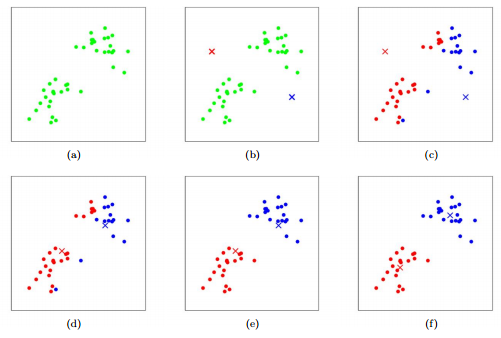

### 1.4. The Objective Function: Inertia (WCSS)

K-Means is mathematically an optimization problem. The goal is to minimize a function called **Inertia**, also known as the **Within-Cluster Sum of Squares (WCSS)**.

Inertia is the sum of the squared distances from each data point to its assigned cluster centroid.

$$
\text{Inertia (WCSS)} = \sum_{j=1}^{K} \sum_{x_i \in S_j} ||x_i - \mu_j||^2
$$

Where:
* $K$ is the number of clusters.
* $S_j$ is the set of all points in cluster $j$.
* $x_i$ is a single data point.
* $\mu_j$ is the centroid of cluster $j$.
* $||x_i - \mu_j||^2$ is the squared Euclidean distance.

A lower inertia value means the clusters are more compact (points are closer to their centroid), which is generally better.

### 1.5. 📈 How to Choose the Optimal K: The Elbow Method

The biggest challenge with K-Means is choosing the right value for *K* beforehand. The **Elbow Method** is the most common technique used to find a good K.

1.  **Run K-Means:** Run the algorithm multiple times with an increasing number of clusters (e.g., K=1, 2, 3, ..., 10).
2.  **Record Inertia:** For each value of K, record the total Inertia (WCSS).
3.  **Plot the Curve:** Plot K on the x-axis and Inertia on the y-axis.
4.  **Find the "Elbow":** The graph will typically show Inertia decreasing rapidly at first and then slowing down, forming a bend (an "elbow"). The "elbow" point on the graph represents a good balance—it's the point where adding another cluster doesn't significantly reduce the total within-cluster variance.

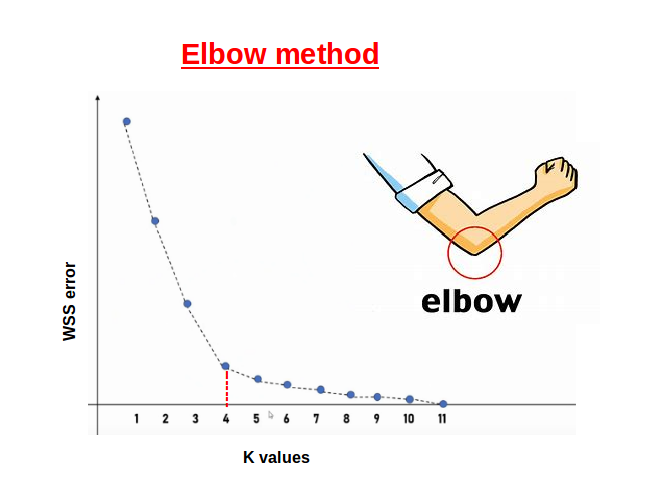

### 1.6. Advantages and Disadvantages

**Pros:**
* **Simple:** Easy to understand and implement.
* **Fast & Scalable:** Computationally efficient, even on large datasets.
* **Guaranteed Convergence:** Always converges to a solution (though not necessarily the *best* one).

**Cons:**
* **Must Specify K:** You must choose the number of clusters *K* in advance. The Elbow Method helps but isn't always perfect.
* **Sensitive to Initialization:** The final clusters can change based on the initial random placement of centroids. (Using `init='k-means++'` helps fix this).
* **Assumes Spherical Clusters:** K-Means works best when clusters are spherical, similar in size, and evenly dense. It struggles with long, thin, or irregularly shaped clusters.
* **Sensitive to Outliers:** A single outlier can significantly pull a centroid away from its true center.
* **Requires Scaled Data:** Since it's based on Euclidean distance, K-Means is highly sensitive to the scale of features. **Features must be scaled** (e.g., using `StandardScaler` or `MinMaxScaler`) before applying the algorithm.

## 2. Surpress warnings and Import necessary libraries

Suppress warnings for cleaner output and import required libraries:
- `numpy`, `pandas`: For data manipulation.
- `matplotlib`, `seaborn`: For visualization.
- `sklearn`: For machine learning models and evaluation.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [ ]:
# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

## 3. Load and Explore Dataset

Load the preprocessed dataset `Wine_clean.csv` and perform initial checks.

### Basic Information
- Display shape, head, info, and descriptive statistics.

### Distributions
- Check feature distributions and correlations.
- Visualize the distributions and correlations to frame the task (binary classification).

In [ ]:
# Load dataset
df = pd.read_csv("Data/Wine_clean.csv")
# Drop the 'Unnamed: 0' column if exists
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
print(df.shape)
df.head()

(1194, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.524869,1.075573,-1.377452,-0.646558,-0.173311,-0.454417,-0.312763,0.766056,1.408196,-0.621576,-0.989805,5
1,-0.250994,2.167738,-1.377452,0.937243,1.365747,1.133715,0.952872,0.142508,-0.938945,0.411596,-0.579638,5
2,-0.250994,1.439628,-1.155393,0.258471,0.946004,-0.000665,0.454289,0.267217,-0.484660,0.153303,-0.579638,5
3,2.076938,-1.472812,1.731370,-0.646558,-0.243268,0.226211,0.684404,0.890766,-1.241802,-0.449381,-0.579638,6
4,-0.524869,1.075573,-1.377452,-0.646558,-0.173311,-0.454417,-0.312763,0.766056,1.408196,-0.621576,-0.989805,5


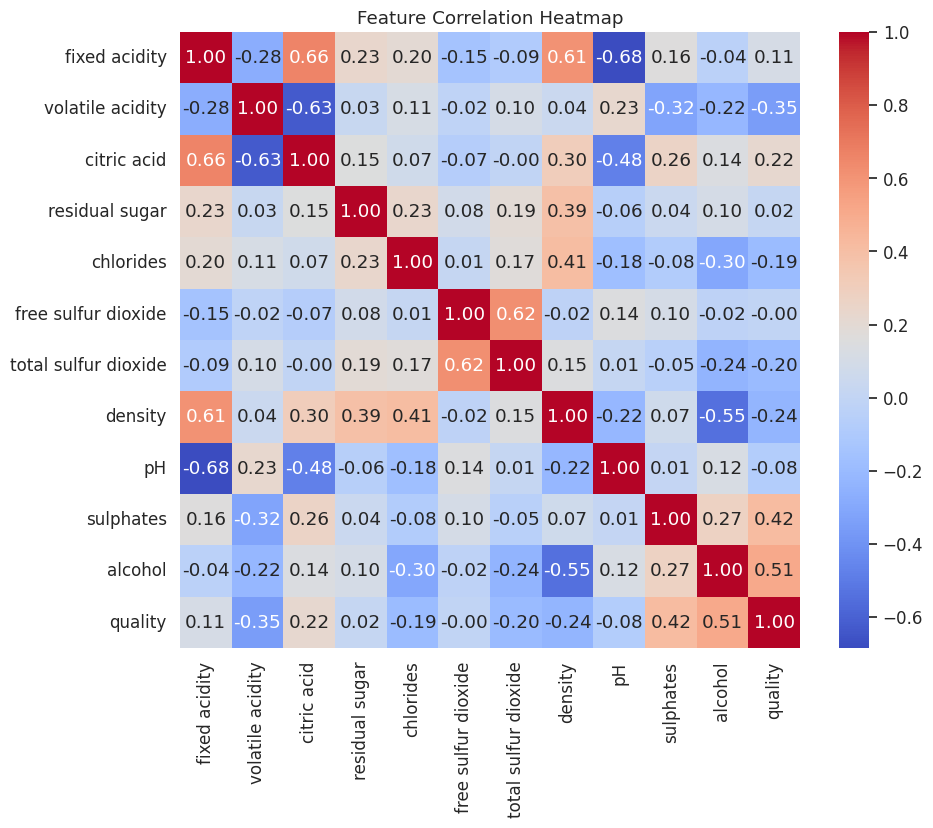

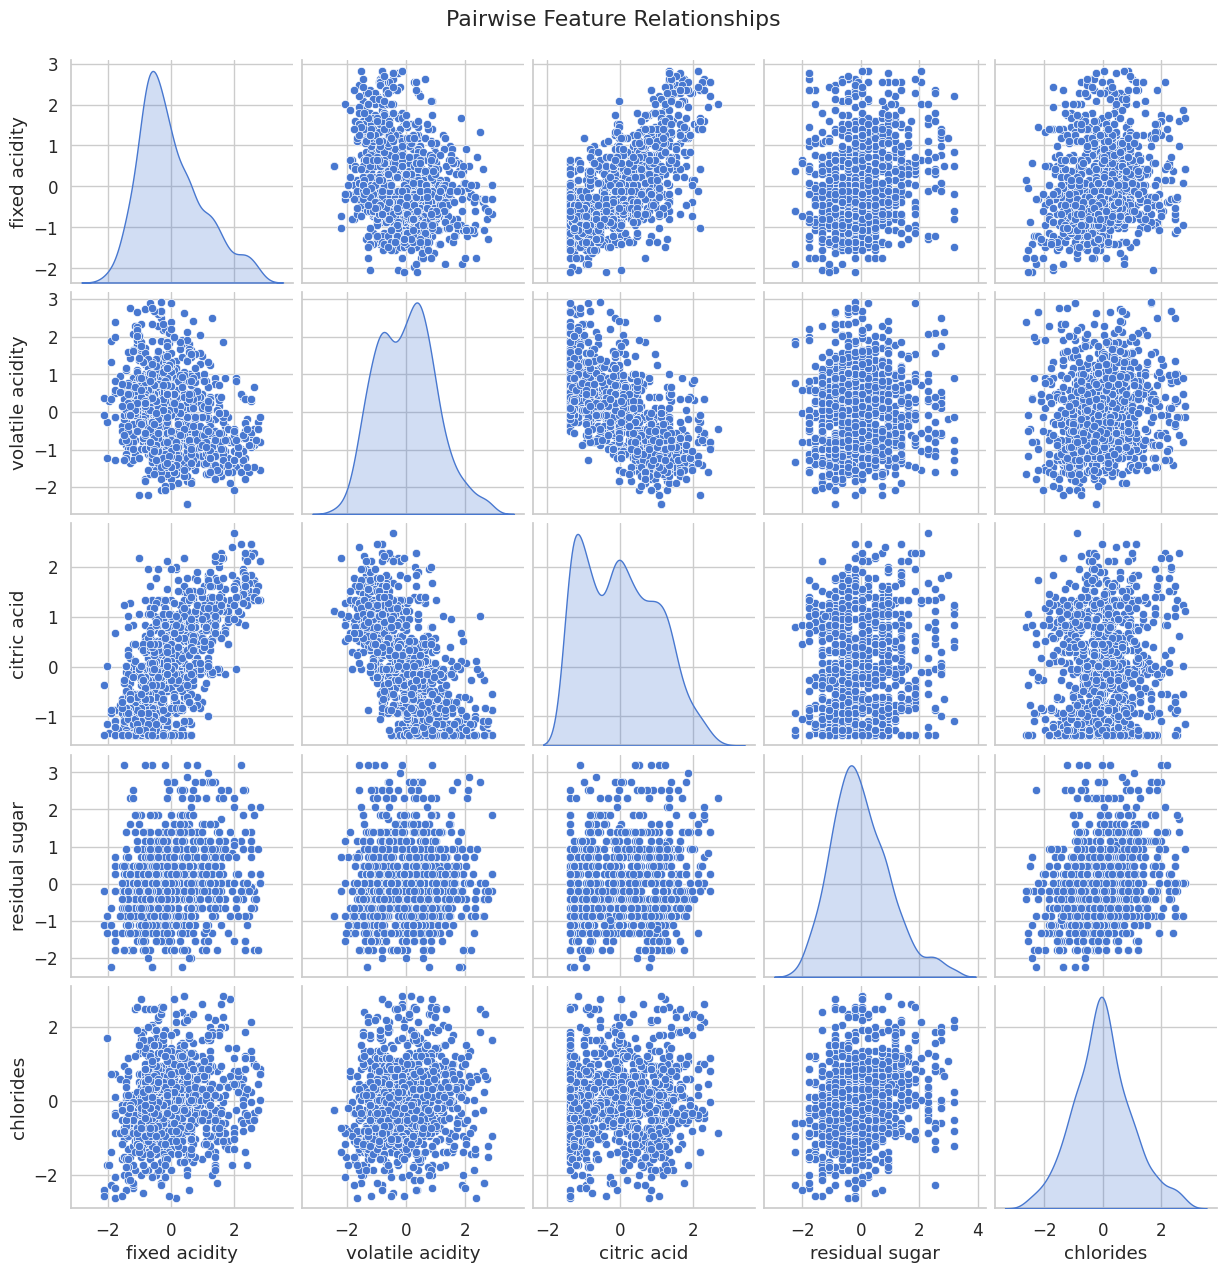

In [ ]:
# Summary statistics
df.describe()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Pairplot for first few columns
sns.pairplot(df.iloc[:, :5], diag_kind="kde")
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()


## 4. Data Preparation for Clustering

The `Wine_clean.csv` dataset is used, which is already scaled (a critical prerequisite for K-Means, as it is distance-based).

### Defining Features (X) and Ground Truth (y)

For this exercise, we will perform **unsupervised clustering**. This means the K-Means algorithm will **not** use the `quality` or `label` columns during training. The model must find patterns on its own using only the wine's chemical features.

* `X`: The features (e.g., fixed acidity, alcohol) used for clustering.
* `y`: The *true* binary label (0 = Not Good, 1 = Good). We will hide this from the model and only use it at the very end to **evaluate** how well the unsupervised clusters match the real-world quality.

In [ ]:
X = df.drop('quality', axis=1)

## 5. Model 1: K-Means from Scratch

First, we will build and train the K-Means algorithm from scratch to understand its internal logic. The class below implements the `fit` method based on the iterative "Assign & Update" steps described in the theory section.

In [ ]:
# Compute inertia and silhouette score for different k values (2–10)
inertias = []
silhouette_scores = []
K_range = range(2, 11)

# Fit KMeans for each k and store evaluation metrics
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))

# Comparison table
results = pd.DataFrame({
    'k': list(K_range),
    'Inertia (WCSS)': inertias,
    'Silhouette Score': silhouette_scores
})
results


,k,Inertia (WCSS),Silhouette Score
0,2,10744.094099,0.182930
1,3,9436.957066,0.156291
2,4,8443.648012,0.163541
3,5,7837.501724,0.160116
4,6,7454.129044,0.153838
5,7,7183.527223,0.131246
6,8,6849.973657,0.132315
7,9,6632.954200,0.128739
8,10,6437.550790,0.125136


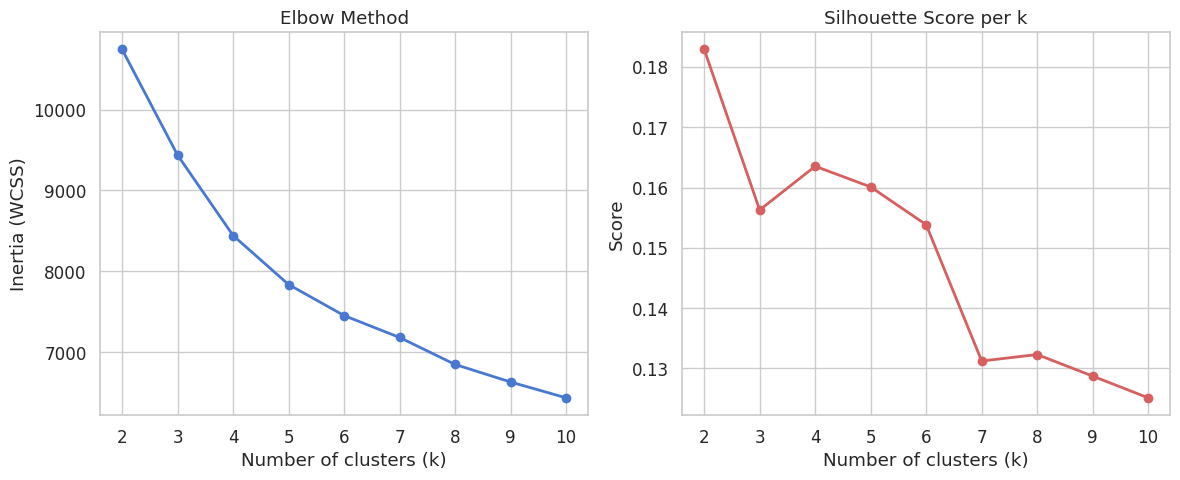

Best k (based on Silhouette Score): 2


In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2)
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-', linewidth=2)
plt.title('Silhouette Score per k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

best_k = results.loc[results['Silhouette Score'].idxmax(), 'k']
print(f"Best k (based on Silhouette Score): {best_k}")


## 6. Evaluation (K=2)

We fit our custom model with `K=2`, hoping it will find the two *true* labels (Good/Not Good). We evaluate it using the **Silhouette Score**.

* **Silhouette Score:** Measures how similar a data point is to its own cluster compared to other clusters. It ranges from -1 to 1.
    * `+1`: Clusters are dense and well-separated.
    * ` 0`: Clusters overlap.
    * `-1`: Points were likely assigned to the wrong cluster.

Our score of **0.283** is positive but not very high, suggesting the clusters are not clearly distinct. This could mean K=2 is not the right number, or the data is simply not well-separated.

In [ ]:
final_kmeans = KMeans(n_clusters=int(best_k), random_state=42)
final_kmeans.fit(X)
df['cluster'] = final_kmeans.labels_

# Display cluster distribution
df['cluster'].value_counts().sort_index()


,count
cluster,
0,485
1,709


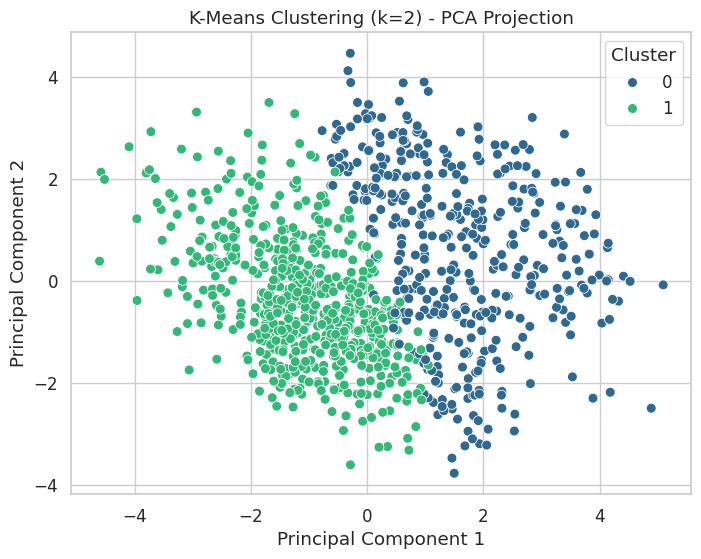

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='viridis', s=50)
plt.title(f"K-Means Clustering (k={best_k}) - PCA Projection")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
pd.crosstab(df['cluster'], df['quality'])


quality,3,4,5,6,7,8
cluster,,,,,,
0,1,8,161,205,100,10
1,2,25,352,293,35,2


In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

labels = df['cluster']
print("Silhouette Score:", silhouette_score(X, labels))
print("Calinski-Harabasz:", calinski_harabasz_score(X, labels))
print("Davies-Bouldin:", davies_bouldin_score(X, labels))


Silhouette Score: 0.1829304137744871
Calinski-Harabasz: 265.1473272011854
Davies-Bouldin: 2.031459109604879


## 7. Conclusion and Analysis

Based on the clustering evaluation metrics, we can draw a comprehensive conclusion about the structure of the `Wine_clean` dataset.

### 7.1. Summary of Metrics

The performance of the K-Means algorithm is summarized by the following metrics:

| Metric | Value | Interpretation |
| :--- | :---: | :--- |
| **Silhouette Score** | 0.1829 | **Low.** Values near 0 indicate that clusters are weak, indistinct, or overlapping. |
| **Calinski-Harabasz** | 265.15 | **Medium-Low.** This suggests there is *some* light structure, but the clusters are not dense and well-separated. |
| **Davies-Bouldin** | 2.0314 | **High.** A value over 2.0 strongly suggests that the clusters are overlapping and not well-partitioned. |

### 7.2. Final Analysis

**The primary finding is that the data does not contain distinct, well-separated clusters.**

All three metrics consistently point to the same conclusion: the clusters are **poorly defined and overlap significantly**.

As noted in the analysis, this is **not a failure of the K-Means model**, but rather an intrinsic characteristic of the data itself:

1.  **Data Nature:** The `Wine_clean` dataset has already been standardized and cleaned. The features themselves (e.g., acidity, alcohol) exist on a **continuum**. It is logical that the boundaries between different quality levels are "fuzzy" and continuous, not distinct, hard-edged groups. K-Means, being a distance-based algorithm, struggles to find clear partitions in such data.
2.  **Low Correlation:** The dataset's features have low correlation (ranging from -0.68 to 0.66). This means the features are already largely independent.
3.  **Ineffectiveness of PCA:** Because the features are already standardized and have low correlation, dimensionality reduction techniques like **PCA (Principal Component Analysis) would not improve the clustering results**. PCA works by identifying principal components from *highly correlated* variables, which are not present here.

Therefore, the low metric scores are themselves the result: the wine quality data is more of a continuous spectrum than a set of discrete, separable groups.